# Air Quality prediction model search

Loop and grid search for the optimal air quality model.

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd

import contextily
import palettable.matplotlib as palmpl
import matplotlib.pyplot as plt
import mapclassify
import libpysal

from utils import legendgram

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, GridSearchCV

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_14176/881383173.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
data_folder = "/Users/martin/Library/CloudStorage/OneDrive-SharedLibraries-TheAlanTuringInstitute/Daniel Arribas-Bel - demoland_data"

Load the data

In [4]:
data = gpd.read_parquet(f"{data_folder}/processed/interpolated/all_oa.parquet")

Filter only explanatory variables.

In [5]:
exvars = data.drop(
    columns=[
        "geo_code",
        "geometry",
        "air_quality_index",
        "house_price_index",
        "jobs_accessibility_index",
        "greenspace_accessibility_index",
    ]
)

Specify grid search parameters. We can limit the options based on previous exploration.

In [6]:
parameters = {"learning_rate": (0.05, 0.1), "max_iter": [500], "max_bins": (64, 128)}

Define the simple weights matrices.

In [8]:
queen = libpysal.weights.Queen.from_dataframe(data)
weights = {
    "queen": queen,
    "queen2": libpysal.weights.higher_order(queen, k=2, lower_order=True),
    "queen3": libpysal.weights.higher_order(queen, k=3, lower_order=True),
    "queen4": libpysal.weights.higher_order(queen, k=4, lower_order=True),
    "queen5": libpysal.weights.higher_order(queen, k=5, lower_order=True),
    "500m": libpysal.weights.DistanceBand.from_dataframe(data, 500),
    "1000m": libpysal.weights.DistanceBand.from_dataframe(data, 1000),
    "2000m": libpysal.weights.DistanceBand.from_dataframe(data, 2000),
}

/Users/martin/mambaforge/envs/demoland/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
/Users/martin/mambaforge/envs/demoland/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 110 disconnected components.
 There are 82 islands with ids: 47, 71, 72, 89, 263, 361, 364, 375, 376, 377, 378, 541, 642, 983, 993, 1092, 1220, 1295, 1339, 1343, 1345, 1383, 1406, 1640, 1756, 1772, 1809, 1851, 1944, 1958, 2124, 2148, 2181, 2182, 2188, 2195, 2214, 2222, 2223, 2237, 2265, 2277, 2281, 2283, 2307, 2361, 2485, 2493, 2594, 2686, 2766, 2809, 2825, 2868, 2940, 2980, 3091, 3094, 3112, 3146, 3191, 3197, 3207, 3223, 3235, 3276, 3397, 3400, 3415, 3419, 3423, 3427, 3451, 3475, 3488, 3528, 3555, 3577, 3707, 3723, 3743, 3778.
  warnings.warn(message)
/Users/martin/mambaforge/envs/demoland/lib/python3.

Use Grid Search CV to find the best model for each weights option.

In [9]:
meta = {}
for name, W in weights.items():
    W.transform = "r"
    exvars = data.drop(
        columns=[
            "geo_code",
            "geometry",
            "air_quality_index",
            "house_price_index",
            "jobs_accessibility_index",
            "greenspace_accessibility_index",
        ]
    )
    for col in exvars.columns.copy():
        exvars[f"{col}_lag"] = libpysal.weights.spatial_lag.lag_spatial(W, exvars[col])
    regressor_lag = HistGradientBoostingRegressor(
        random_state=0,
    )
    est_lag = GridSearchCV(regressor_lag, parameters, verbose=1)
    est_lag.fit(exvars, data.air_quality_index)
    meta[name] = {"score": est_lag.best_score_}
    y_pred_lag = cross_val_predict(
        est_lag.best_estimator_, exvars, data.air_quality_index, cv=5
    )
    pred_lag = pd.Series(y_pred_lag, index=data.index)
    residuals_lag = data.air_quality_index - pred_lag
    meta[name]["mse"] = mean_squared_error(data.air_quality_index, pred_lag)
    meta[name]["me"] = residuals_lag.abs().mean()
    meta[name]["prediction"] = pred_lag
    meta[name]["residuals"] = residuals_lag
    meta[name]["model"] = est_lag.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 71, ' is an island (no neighbors)')
('WARNING: ', 72, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')
('WARNING: ', 263, ' is an island (no neighbors)')
('WARNING: ', 361, ' is an island (no neighbors)')
('WARNING: ', 364, ' is an island (no neighbors)')
('WARNING: ', 375, ' is an island (no neighbors)')
('WARNING: ', 376, ' is an island (no neighbors)')
('WARNING: ', 377, ' is an island (no neighbors)')
('WARNING: ', 378, ' is an island (no neighbors)')
('WARNING: ', 541, ' is an island (no neighbors)')
('WARNING: ', 642, ' is an island (no neighbors)')
('WARNING: ', 983, ' is an island (no nei

Add combined weights on top.

In [16]:
combined_weigts = {
    "queen500m": libpysal.weights.w_union(weights["queen"], weights["500m"]),
    "queen1000m": libpysal.weights.w_union(weights["queen"], weights["1000m"]),
    "queen2000m": libpysal.weights.w_union(weights["queen"], weights["2000m"]),
}

Find models.

In [17]:
for name, W in combined_weigts.items():
    W.transform = "r"
    exvars = data.drop(
        columns=[
            "geo_code",
            "geometry",
            "air_quality_index",
            "house_price_index",
            "jobs_accessibility_index",
            "greenspace_accessibility_index",
        ]
    )
    for col in exvars.columns.copy():
        exvars[f"{col}_lag"] = libpysal.weights.spatial_lag.lag_spatial(W, exvars[col])
    regressor_lag = HistGradientBoostingRegressor(
        random_state=0,
    )
    est_lag = GridSearchCV(regressor_lag, parameters, verbose=1)
    est_lag.fit(exvars, data.air_quality_index)
    meta[name] = {"score": est_lag.best_score_}
    y_pred_lag = cross_val_predict(
        est_lag.best_estimator_, exvars, data.air_quality_index, cv=5
    )
    pred_lag = pd.Series(y_pred_lag, index=data.index)
    residuals_lag = data.air_quality_index - pred_lag
    meta[name]["mse"] = mean_squared_error(data.air_quality_index, pred_lag)
    meta[name]["me"] = residuals_lag.abs().mean()
    meta[name]["prediction"] = pred_lag
    meta[name]["residuals"] = residuals_lag
    meta[name]["model"] = est_lag.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


Save evaluation metrics as series.

In [19]:
mse = pd.Series([vals["mse"] for vals in meta.values()], index=meta.keys())
me = pd.Series([vals["me"] for vals in meta.values()], index=meta.keys())
score = pd.Series([vals["score"] for vals in meta.values()], index=meta.keys())

Sort according to MSE. Lower is better.

In [20]:
mse.sort_values()

queen2000m    0.505627
queen4        0.510048
2000m         0.520661
queen5        0.523149
queen3        0.544779
1000m         0.671224
queen1000m    0.677756
queen2        0.714267
queen500m     0.826434
queen         0.919178
500m          0.947078
dtype: float64

Sort according to ME. Lower is better.

In [21]:
me.sort_values()

queen2000m    0.445121
2000m         0.453738
queen4        0.481805
queen5        0.486240
queen3        0.514920
1000m         0.551970
queen1000m    0.558655
queen2        0.601619
queen500m     0.658718
500m          0.708802
queen         0.712700
dtype: float64

Sort according to R2. Higher is better.

In [22]:
score.sort_values()

queen         0.553838
500m          0.563087
queen500m     0.615798
queen2        0.690342
queen1000m    0.721429
1000m         0.724661
queen3        0.762028
queen5        0.780816
queen4        0.782347
2000m         0.803538
queen2000m    0.807554
dtype: float64

The optimal model seems to use a combination of Queen weights and Distance Band 2000m. Let's explore it.

The actual vs predicted values.

Text(0, 0.5, 'Y pred')

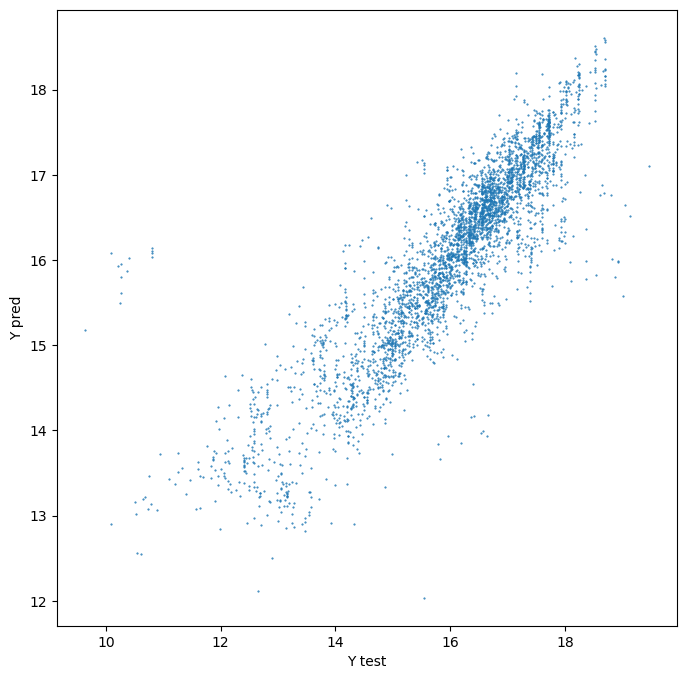

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(data.air_quality_index, meta["queen2000m"]["prediction"], s=0.25)
plt.xlabel("Y test")
plt.ylabel("Y pred")

Plot the values using the original cmap.

In [24]:
from shapely.geometry import box

bds = data.total_bounds
extent = gpd.GeoSeries(
    [box((bds[0] - 7000), bds[1], bds[2] + 7000, bds[3])], crs=data.crs
).to_crs(3857)

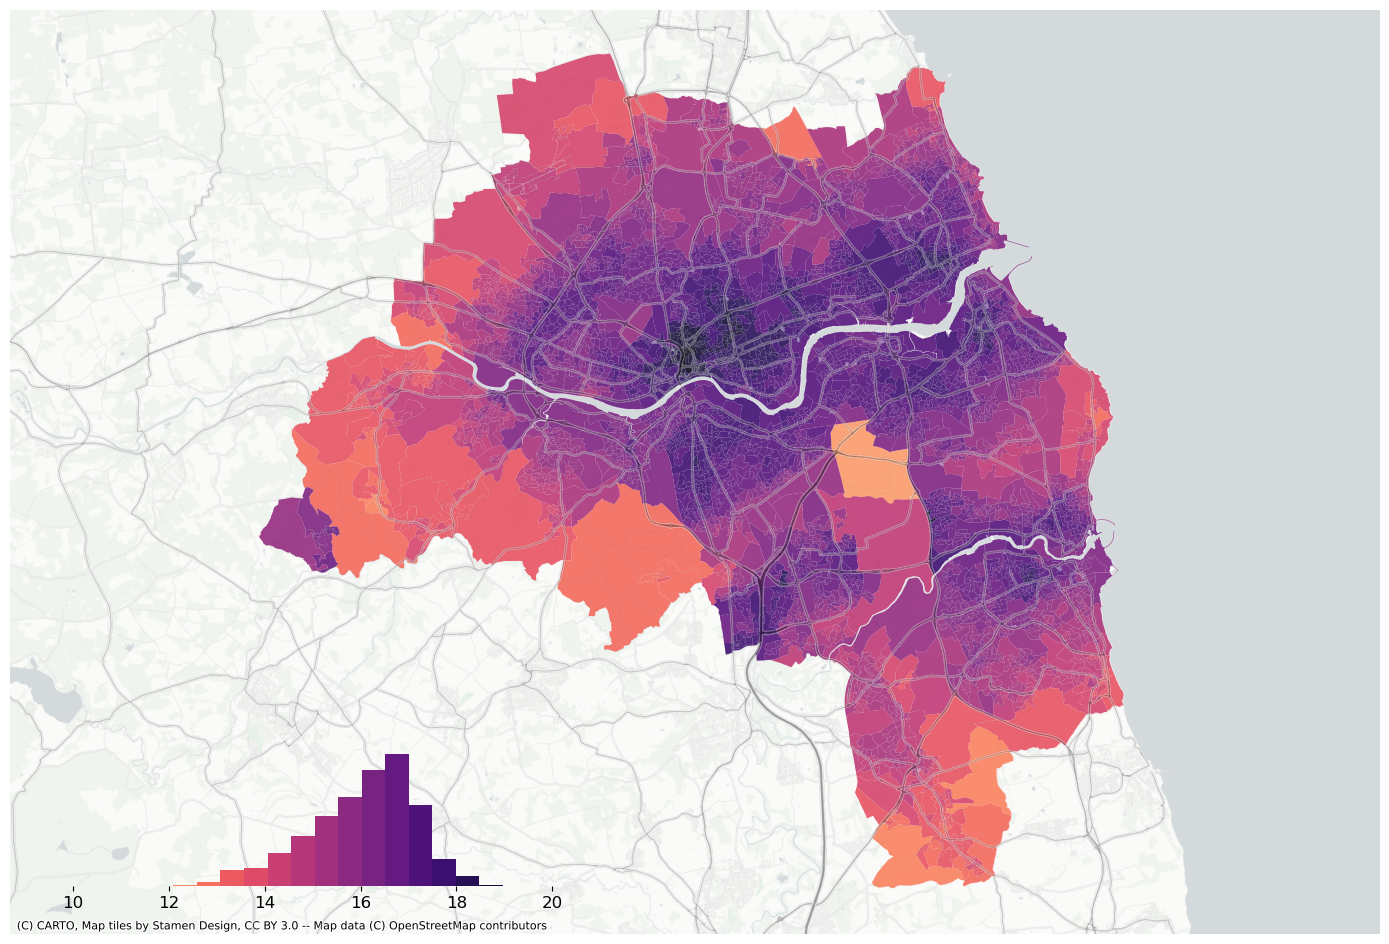

In [25]:
f, ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.EqualInterval(data["air_quality_index"].values, k=20).bins

data.assign(pred=meta["queen2000m"]["prediction"]).to_crs(3857).plot(
    "pred",
    scheme="userdefined",
    classification_kwds={"bins": bins},
    ax=ax,
    alpha=0.9,
    cmap="magma_r",
)
legendgram(
    f,
    ax,
    meta["queen2000m"]["prediction"],
    bins,
    pal=palmpl.Magma_20_r,
    legend_size=(0.35, 0.15),  # legend size in fractions of the axis
    loc="lower left",  # matplotlib-style legend locations
    clip=(10, 20),  # clip the displayed range of the histogram
)
ax.set_axis_off()
contextily.add_basemap(
    ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution=""
)
contextily.add_basemap(
    ax=ax,
    source=contextily.providers.Stamen.TonerLines,
    alpha=0.4,
    attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors",
)
# plt.savefig(f"{data_folder}/outputs/figures/air_quality_index.png", dpi=150, bbox_inches="tight")

Plot residuals.

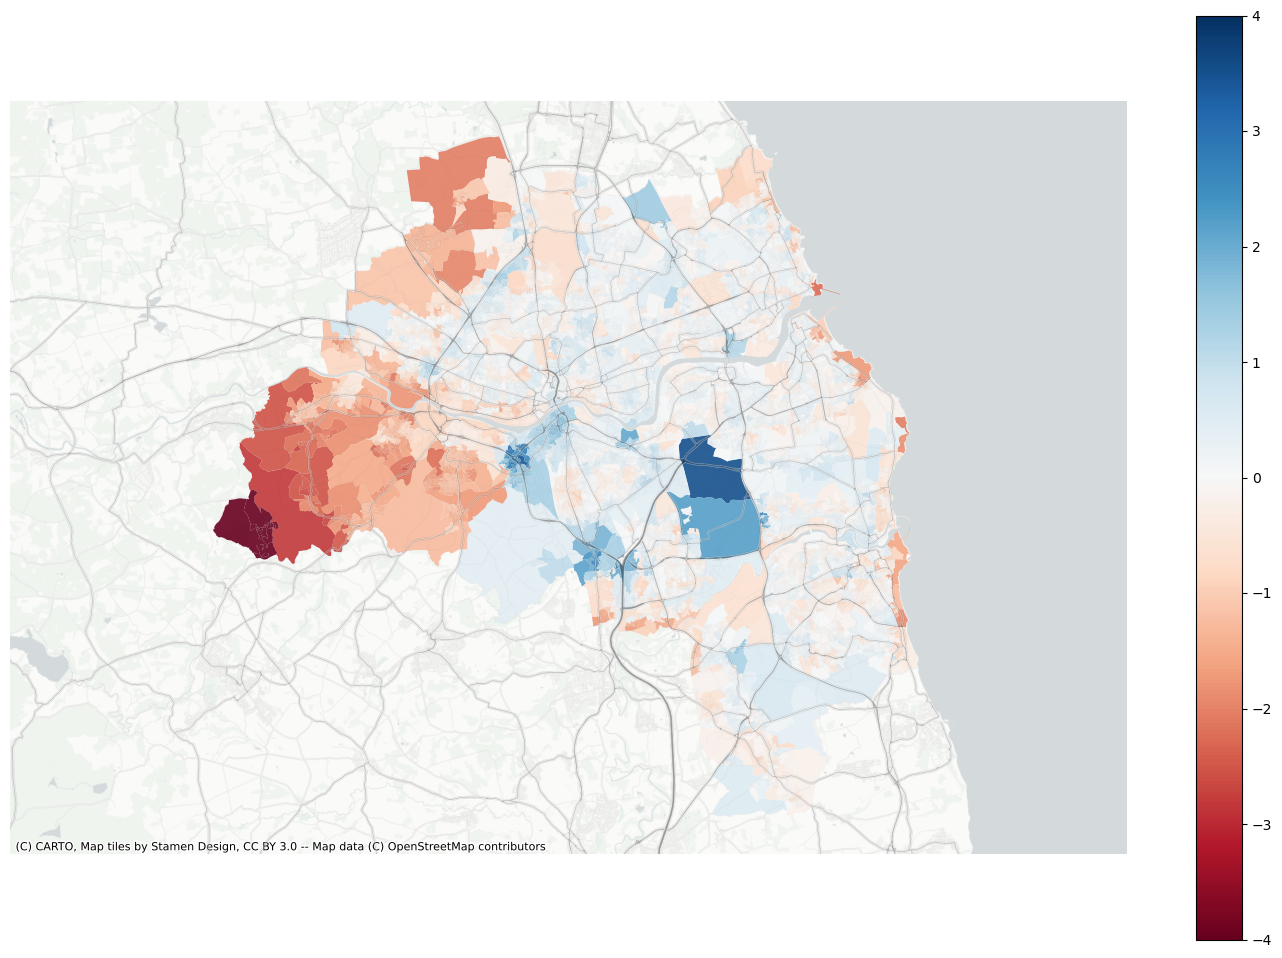

In [26]:
f, ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
data.assign(res=meta["queen2000m"]["residuals"]).to_crs(3857).plot(
    "res", ax=ax, alpha=0.9, cmap="RdBu", vmin=-4, vmax=4, legend=True
)
ax.set_axis_off()
contextily.add_basemap(
    ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution=""
)
contextily.add_basemap(
    ax=ax,
    source=contextily.providers.Stamen.TonerLines,
    alpha=0.4,
    attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors",
)
# plt.savefig(f"{data_folder}/outputs/figures/air_quality_index.png", dpi=150, bbox_inches="tight")

It seems that large OAs are less precise. Green belt tends to be overpredicted whuile some more central areas underpredicted. However, the error across the area is minimal.

We can save the meta dict with all the data. The final model is part of that.

In [1]:
import pickle

In [29]:
with open(f"{data_folder}/models/air_quality_meta.pickle", "wb") as f:
    pickle.dump(meta, f)

Save just the model for easy inference.

In [8]:
with open(f"{data_folder}/models/air_quality_model.pickle", "wb") as f:
    pickle.dump(meta["queen2000m"]["model"], f)